In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/test.csv


Import the necessary packages

In [2]:
import keras
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout, Flatten, add
from keras.layers import Conv2D, Activation, MaxPooling2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.models import Model
from keras.utils import plot_model
from keras.preprocessing. image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, PReLU, Dropout
from keras.models import Model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import seaborn as sns
sns.set()
%matplotlib inline

Using TensorFlow backend.


EDA

In [3]:
%%time
train_data = pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
test_data = pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')

CPU times: user 5.51 s, sys: 532 ms, total: 6.04 s
Wall time: 6.08 s


View label distribution

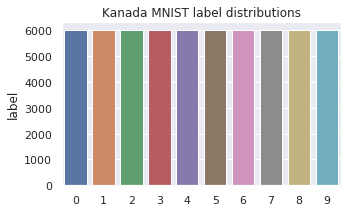

In [4]:
label_values=train_data['label'].value_counts().sort_index()
plt.figure(figsize=(5,3))
plt.title("Kanada MNIST label distributions")
sns.barplot(x=label_values.index, y=label_values)

Converting CSV data into images

In [5]:
img_train = train_data.drop(["label"], axis=1).values.reshape(-1, 28, 28, 1).astype('float32')
img_label = train_data["label"]
img_test = test_data.drop(["id"], axis=1).values.reshape(-1, 28, 28, 1).astype('float32')
print("img_train.shape = ", img_train.shape)
print("img_label.shape = ", img_label.shape)
print("img_test.shape = ", img_test.shape)

img_train.shape =  (60000, 28, 28, 1)
img_label.shape =  (60000,)
img_test.shape =  (5000, 28, 28, 1)


View some sample images

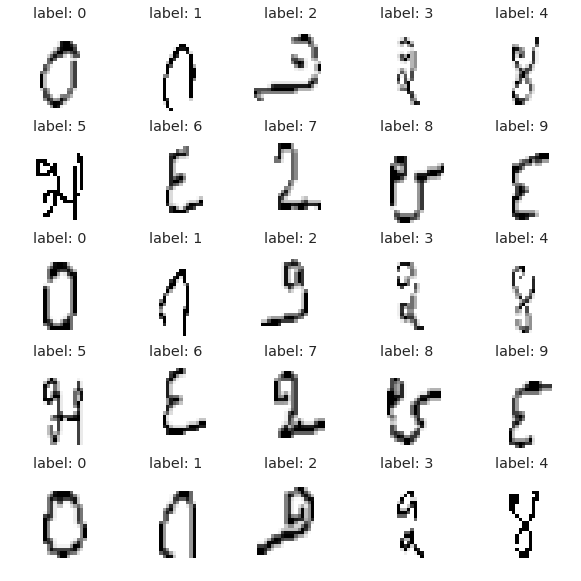

In [20]:
fig = plt.figure(figsize=(10, 10))
show_img = 0
for idx in range(img_train.shape[0]):
    plt.subplot(5, 5, show_img + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_train[idx].reshape(28, 28), cmap=plt.cm.binary)
    plt.title("label: %d" % img_label[idx])
    show_img += 1
    if show_img % 25 == 0:
        break

build cnn model

In [7]:
def build_model(input_shape=(28, 28, 1), num_classes = 10):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3,3), strides=1, padding="same", name="conv1")(input_layer)
    x = PReLU()(x)
    x = Conv2D(32, (3,3), strides=1, padding="same", name="conv2")(x)
    x = PReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), name="pool2")(x)
    x = Conv2D(64, (5,5), strides=1, padding="same", name="conv3")(x)
    x = PReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), name="pool3")(x)
    x = Conv2D(64, (5,5), strides=1, padding="same", name="conv4")(x)
    x = PReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), name="pool4")(x)
    x = Conv2D(128, (5,5), strides=1, padding="same", name="conv5")(x)
    x = PReLU()(x)
    x = Conv2D(128, (5,5), strides=1, padding="same", name="conv6")(x)
    x = PReLU()(x)
    x = Flatten()(x)
    x = Dense(512, name="full1")(x)
    x = PReLU()(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax', name="output")(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

In [8]:
model = build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 28, 28, 32)        25088     
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 32)        9248      
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 28, 28, 32)        25088     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 14, 14, 64)        5126

split train data to train and test

In [9]:
from sklearn.model_selection import train_test_split
X_data = img_train / 255
Y_data = to_categorical(img_label)
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.1)
print("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)
print("x_test.shape = ", x_test.shape)
print("y_test.shape = ", y_test.shape)

x_train.shape =  (54000, 28, 28, 1)
y_train.shape =  (54000, 10)
x_test.shape =  (6000, 28, 28, 1)
y_test.shape =  (6000, 10)


Image Data Augmentation

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=9, 
    zoom_range=0.25, 
    width_shift_range=0.25, 
    height_shift_range=0.25
)
train_datagen.fit(x_train)
sgd = SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)
checkpoint = ModelCheckpoint("bestmodel.model", monitor='val_accuracy', verbose=1, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='min')

In [11]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [12]:
epochs = 100
batch_size = 64

start training model

In [13]:
history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint, learning_rate_reduction])

Epoch 1/100
843/843 [==============================] - 26s 31ms/step - loss: 2.3008 - accuracy: 0.1355 - val_loss: 2.2942 - val_accuracy: 0.4520

Epoch 00001: val_accuracy improved from -inf to 0.45200, saving model to bestmodel.model
Epoch 2/100
843/843 [==============================] - 22s 26ms/step - loss: 2.2846 - accuracy: 0.2165 - val_loss: 2.1530 - val_accuracy: 0.4450

Epoch 00002: val_accuracy did not improve from 0.45200
Epoch 3/100
843/843 [==============================] - 22s 26ms/step - loss: 1.3005 - accuracy: 0.5556 - val_loss: 0.2560 - val_accuracy: 0.9225

Epoch 00003: val_accuracy improved from 0.45200 to 0.92250, saving model to bestmodel.model
Epoch 4/100
843/843 [==============================] - 23s 27ms/step - loss: 0.4472 - accuracy: 0.8520 - val_loss: 0.0960 - val_accuracy: 0.9688

Epoch 00004: val_accuracy improved from 0.92250 to 0.96883, saving model to bestmodel.model
Epoch 5/100
843/843 [==============================] - 22s 26ms/step - loss: 0.2958 - ac

843/843 [==============================] - 21s 25ms/step - loss: 0.0529 - accuracy: 0.9824 - val_loss: 0.0159 - val_accuracy: 0.9948

Epoch 00038: val_accuracy improved from 0.99450 to 0.99483, saving model to bestmodel.model
Epoch 39/100
843/843 [==============================] - 21s 25ms/step - loss: 0.0540 - accuracy: 0.9826 - val_loss: 0.0141 - val_accuracy: 0.9952

Epoch 00039: val_accuracy improved from 0.99483 to 0.99517, saving model to bestmodel.model
Epoch 40/100
843/843 [==============================] - 22s 26ms/step - loss: 0.0507 - accuracy: 0.9837 - val_loss: 0.0158 - val_accuracy: 0.9943

Epoch 00040: val_accuracy did not improve from 0.99517
Epoch 41/100
843/843 [==============================] - 22s 26ms/step - loss: 0.0497 - accuracy: 0.9833 - val_loss: 0.0165 - val_accuracy: 0.9942

Epoch 00041: val_accuracy did not improve from 0.99517
Epoch 42/100
843/843 [==============================] - 22s 26ms/step - loss: 0.0503 - accuracy: 0.9830 - val_loss: 0.0152 - val_ac


Epoch 00075: val_accuracy did not improve from 0.99533
Epoch 76/100
843/843 [==============================] - 22s 26ms/step - loss: 0.0435 - accuracy: 0.9857 - val_loss: 0.0136 - val_accuracy: 0.9952

Epoch 00076: val_accuracy did not improve from 0.99533
Epoch 77/100
843/843 [==============================] - 21s 25ms/step - loss: 0.0421 - accuracy: 0.9858 - val_loss: 0.0136 - val_accuracy: 0.9952

Epoch 00077: val_accuracy did not improve from 0.99533
Epoch 78/100
843/843 [==============================] - 22s 27ms/step - loss: 0.0417 - accuracy: 0.9862 - val_loss: 0.0136 - val_accuracy: 0.9952

Epoch 00078: val_accuracy did not improve from 0.99533

Epoch 00078: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.
Epoch 79/100
843/843 [==============================] - 21s 25ms/step - loss: 0.0415 - accuracy: 0.9865 - val_loss: 0.0136 - val_accuracy: 0.9952

Epoch 00079: val_accuracy did not improve from 0.99533
Epoch 80/100
843/843 [==============================] 

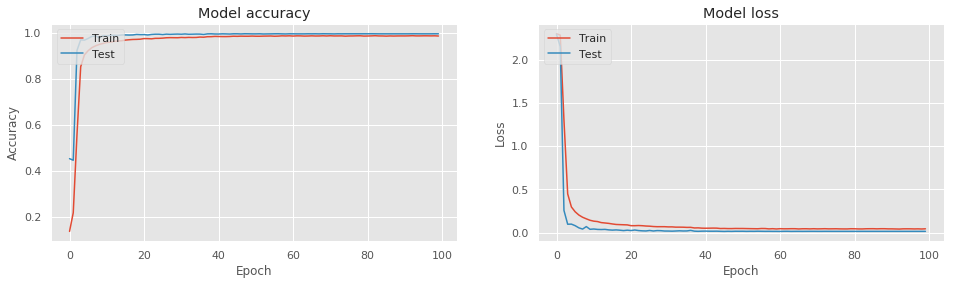

In [19]:
plt.style.use("ggplot")
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

predict test data

In [21]:
results=model.predict(img_test/255.0)
results=np.argmax(results, axis=1)

show some predict image

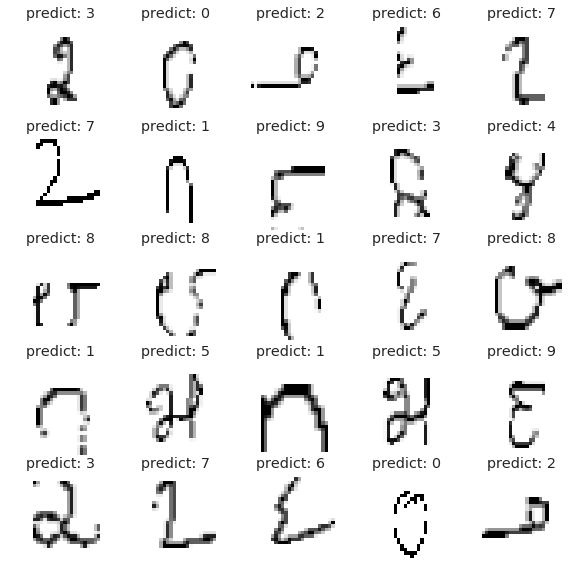

In [22]:
fig = plt.figure(figsize=(10, 10))
show_img = 0
for idx in range(img_test.shape[0]):
    plt.subplot(5, 5, show_img + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_test[idx].reshape(28, 28), cmap=plt.cm.binary)
    plt.title("predict: %d" % results[idx])
    show_img += 1
    if show_img % 25 == 0:
        break

save to csv file

In [23]:
sub=pd.DataFrame()
sub['id']=list(test_data.values[0:,0])
sub['label']=results
sub.to_csv("submission.csv", index=False)